# Training and Fine-Tuning BERT for Classification
## Classfying newspaper articles by topic

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on news topics discussed [here](https://www.tandfonline.com/doi/full/10.1080/21670811.2020.1767509) with the goal of predicting the topic of a news article. The genres include:

-   'business'
-   'entertainment'
-   'politics'
-   'other'

Please download the data from the [bdaca github](https://github.com/uvacw/teaching-bdaca/tree/main/modules/machinelearning-text-exercises)

**Basic steps involved in using BERT and HuggingFace:**
- Split your dataset into training, validation, and testing subsets.
- Convert your data into a format that BERT can process.
- Create dataset objects by joining your data and labels.
- Load the pre-trained BERT model.
- Refine the model by training it on your training data.
- Use the model to make predictions and assess its performance on your test data.


_This notebook is heavily inspired by Herties BERT for humanities tutorial_

<br><br>

## **Import necessary Python libraries and modules**

In [1]:
#!pip3 install torch

Next, we will import necessary Python libraries and modules.

In [2]:
import gzip
import json
import pickle
import random
import sys
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import torch
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score

from collections import defaultdict

sns.set(style='ticks', font_scale=1.2)
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import compute_sample_weight

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 2020_eScience_Center_Application_Form_Pre-Proposal_ASDI.docx
"Aanvraag 'Verantwoordelijke Waardecreatie'.gdoc"
 abstract-draft.gdoc
'Abstract Social data science.gdoc'
'Academische Werkplaats.gslides'
'Agenda Notulen Heidag Onderzoek.gdoc'
'Amcat4 design.gdraw'
'AmCAT 4 - Functional and Technical Design.gdoc'
'Amsterdam 02-2015'
 application_template_phds_in_the_humanities_2024_0_ilse.docx
'Article features'
'A theory of news sharing.gdoc'
 BERT-mexico-5classes
 BERT-mexico-politics-vs-rest
 BERT-mexico-sports-vs-rest
'Book proposal: Computational Social Science.gdoc'
'breakout room large-scale data collection and infrastructure.gdoc'
'Briefing Motivaction.gdoc'
'budget draft erik damian fb.gsheet'
'Case Studies.gsheet'
 CCR_Journal
 CCR-slide.gslides
'CCS Book Corrections.gsheet'
 Cleaned_Speeches
'Colab Notebooks'
'Computational textbook'
 Computational_tu

<br><br>

## **Read in data, and split into Train-Val-Test (60-20-20) samples**


This will read in the annotated newspaper data from Vermeer et al., and split it into train, val and test samples.


In [4]:

csv.field_size_limit(sys.maxsize)

def get_labeled_data(fn='labeled.csv',textcol=0, labelcol=1):
    text= []
    label= []

    with open(fn) as fi:
        next(fi)
        reader = csv.reader(fi, delimiter=',')
        for row in reader:
            try:
                text.append(row[textcol])
                label.append(row[labelcol])
            except:
                # invalid row, probably an empty one. let's just ignore
                pass
    return text, label

texts, labels = get_labeled_data('/content/drive/MyDrive/manual_annotations_sample.csv', textcol=6, labelcol=7)


# Split your data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [5]:
print(f"We have {len(X_train)} train examples, {len(X_val)} validation examples, and {len(X_test)} test examples.")

We have 600 train examples, 201 validation examples, and 201 test examples.


In [6]:
#We will be using a Dutch model, as our data is Dutch-- specifically the '"GroNLP/bert-base-dutch-cased"' model. Check out Hugging Face's documentation for more information on the different BERT models.
model_name = 'bert-base-cased'

# We'll run our code on NVIDIA GPUs using the program management system.
device_name = 'cuda'
#device_name='cpu'

# We set the maximum number of tokens in each document to be 512, which is the maximum length for BERT models.
max_length = 512

# We define the directory where we'll save our trained model. You can choose any name for the directory.
save_directory = 'my_trained_model'

Here's an example of a training text and training label:

In [7]:
X_train[0], y_train[0]

('Automatic deception detection is a crucial task that has many applications both in direct physical and in computer-mediated human communication. Our focus is on automatic deception detection in text across cultures. In this context, we view culture through the prism of the individualism/collectivism dimension, and we approximate culture by using country as a proxy. Having as a starting point recent conclusions drawn from the social psychology discipline, we explore if differences in the usage of specific linguistic features of deception across cultures can be confirmed and attributed to cultural norms in respect to the individualism/collectivism divide. In addition, we investigate if a universal feature set for cross-cultural text deception detection tasks exists. We evaluate the predictive power of different feature sets and approaches. We create culture/language-aware classifiers by experimenting with a wide range of n-gram features from several levels of linguistic analysis, namel

<br><br>

## **Implementing a Baseline Model using Logistic Regression**

In this step, we train and evaluate a basic TF-IDF baseline model with logistic regression. Despite using a very small dataset, we observe a performance that is better than random. We will now check if BERT can outperform this strong baseline!

In [8]:
vectorizer = TfidfVectorizer()
Xtrain = vectorizer.fit_transform(X_train)
Xtest = vectorizer.transform(X_test)

We train a logistic regression model from scikit-learn on the newspaper training data, and then we use the trained model to make predictions on our test set.

In [9]:
model = LogisticRegression(max_iter=1000).fit(Xtrain, y_train)
predictions = model.predict(Xtest)

We can leverage the `classification_report` function provided by scikit-learn to assess the performance of the logistic regression model in terms of its ability to predict newspaper topics that match the actual labels.

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64        80
           1       0.75      0.88      0.81       121

    accuracy                           0.75       201
   macro avg       0.75      0.72      0.73       201
weighted avg       0.75      0.75      0.74       201



What do you think of this model? Not too bad for a baseline model, right? Lets see whether we can improve this using BERT.

## Encode data for BERT

To prepare our data for use with BERT, we need to encode the texts and labels in a way that the model can understand. Here are the steps we'll follow:

1. Convert the labels from strings to integers.

2. Tokenize the texts, which involves breaking them up into individual words, and then convert the words into "word pieces" that can be matched with their corresponding embedding vectors.

3. Truncate texts that are longer than 512 tokens, or pad texts that are shorter than 512 tokens with a special padding token.

4. Add special tokens to the beginning and end of each document, including a start token, a separator between sentences, and a padding token as necessary.


We will be using the `AutoTokenizer.from_pretrained()` module from HuggingFace library to encode our texts. This module will handle all the encoding for us, including breaking word tokens into word pieces, truncating to 512 tokens, and adding padding and special BERT tokens.

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In this section, we will generate a mapping of our news topics to integer keys. We begin by extracting the unique labels from our dataset and create a dictionary that associates each label with an integer.

In [12]:
unique_labels = set(label for label in y_train)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [13]:
label2id.keys()

dict_keys(['1', '0'])

In [14]:
id2label.keys()

dict_keys([0, 1])

Now let's encode our texts and labels!

In [15]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in y_train]
val_labels_encoded = [label2id[y] for y in y_val]
test_labels_encoded  = [label2id[y] for y in y_test]

**Examine a news article in the training set after encoding**

In [16]:
' '.join(train_encodings[0].tokens[0:100])

'[CLS] Automatic deception detection is a crucial task that has many applications both in direct physical and in computer - mediated human communication . Our focus is on automatic deception detection in text across cultures . In this context , we view culture through the p ##rism of the individual ##ism / collect ##ivism dimension , and we approximate culture by using country as a pro ##xy . Having as a starting point recent conclusions drawn from the social psychology discipline , we explore if differences in the usage of specific linguistic features of deception across cultures can be confirmed'

**Examine a news article in test set after encoding**

In [17]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] A large volume of patients ? opinions ? as online doctor reviews ( O ##DR ##s ) ? are available online in order to access , analyze , and improve patients ? perception ##s about the quality of care ; however , this development needs to be explored further . Drawing on the two - factor theory , this paper aims to mine O ##DR ##s to explore the different de ##ter ##mina ##nts of patient satisfaction ( PS ) and patient di ##ssa ##tisfaction ( PD ) toward the United Kingdom healthcare services . This study collects reviews'

**Examine the training labels after encoding**

In [18]:
set(train_labels_encoded)

{0, 1}

**Examine the test labels after encoding**

In [19]:
set(test_labels_encoded)

{0, 1}

<br><br>

## **Create a custom Torch dataset by following these steps:**

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `val_dataset`, `test_dataset` object from `test_encodings` and `val_encodings`, and `val_labels_encoded` and `test_labels_encoded`.


In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
val_dataset = MyDataset(val_encodings, val_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a news article in the Torch `training_dataset` after encoding**

In [22]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] Automatic deception detection is a crucial task that has many applications both in direct physical and in computer - mediated human communication . Our focus is on automatic deception detection in text across cultures . In this context , we view culture through the p ##rism of the individual ##ism / collect ##ivism dimension , and we approximate culture by using country as a pro ##xy . Having as a starting point recent conclusions drawn from the social psychology discipline , we explore if differences in the usage of specific linguistic features of deception across cultures can be confirmed'

**Examine a news article in the Torch `test_dataset` after encoding**

In [23]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] Public health emerge ##ncies can generate online public opinion on social media platforms such as Wei ##bo . Ex ##ist ##ing studies show that both temporal and spatial factors have an impact on public opinion , topic and sentiment mining of public health emergency micro ##b ##log ##s can realize the monitoring , prediction and guidance of public opinion considering the temporal and spatial factors . Taking the outbreak period of the Delta variant in three different regions of China in 202 ##1 as the research object , this paper constructed a model based on the Late ##nt Di'

In [24]:
len(id2label)

2

<br><br>

## **Initialize the pre-trained BERT model**

We load a pre-trained Dutch BERT model and transfer it to CUDA for efficient computation.

**Note**: If you intend to repeat the fine-tuning process after previously executing the subsequent cells, ensure that you re-run this cell to reload the original pre-trained model before commencing the fine-tuning again.

In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<br><br>

## **Configure the parameters required for fine-tuning BERT**

The following parameters are crucial for fine-tuning BERT and will be specified in the HuggingFace TrainingArguments objects that we will subsequently pass to the HuggingFace Trainer object. While there are numerous other arguments, we'll focus on the fundamental ones and some common pitfalls.

When fine-tuning your own model, it's critical to experiment with these parameters to identify the optimal configuration for your specific dataset.

| Parameter                     | Explanation                                                                                                                          |
|-------------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| `num_train_epochs`            | The total number of training epochs. This refers to how many times the entire dataset will be processed. Too many epochs can lead to overfitting.|
| `per_device_train_batch_size` | The batch size per device during training.                                                                                           |
| `per_device_eval_batch_size`  | The batch size for evaluation.                                                                                                      |
| `warmup_steps`                | The number of warmup steps for the learning rate scheduler. A smaller value is recommended for small datasets.                         |
| `weight_decay`                | The strength of weight decay, which reduces the size of weights, similar to regularization.                                          |
| `output_dir`                  | The directory where the fine-tuned model and configuration files will be saved.                                                     |
| `logging_dir`                 | The directory where logs will be stored.                                                                                            |
| `logging_steps`               | How often to print logging output. This enables us to terminate training early if the loss is not decreasing.                        |
| `evaluation_strategy`         | Evaluates while training so that we can monitor accuracy improvements.                                                              |


<br><br>

## **Fine-tune the BERT model**

Initially, we define a custom evaluation function that returns the accuracy of the model. However, this function can be modified to return other metrics such as precision, recall, F1 score, or any other desired evaluation metric.

In [26]:
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro', sample_weight=compute_sample_weight('balanced', labels))
    return {'accuracy': acc, 'macro_f1': macro_f1}

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.


## **optimize your model based on a metric you select**

In [27]:
#metric_name = 'macro_f1' # you can chance this for `accuracy` etc, according to the function `compute_metrics`
metric_name='f1'

In [28]:
# Instantiate an object of the TrainingArguments class with the following parameters:
training_args = TrainingArguments(

    # Number of training epochs
    num_train_epochs=5,

    # Batch size for training
    per_device_train_batch_size=8,

    # Batch size for evaluation
    per_device_eval_batch_size=8,

    # Learning rate for optimization
    learning_rate=5e-5,

    # Load the best model at the end of training
    load_best_model_at_end=True,

    # Metric used for selecting the best model
    metric_for_best_model=metric_name,

    # Number of warmup steps for the optimizer
    warmup_steps=0,

    # L2 regularization weight decay
    weight_decay=0.01,

    # Directory to save the fine-tuned model and configuration files
    output_dir='./results',

    # Directory to store logs
    logging_dir='./logs',

    # Log results every n steps
    logging_steps=20,

    # Strategy for evaluating the model during training
    evaluation_strategy='steps',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
#pip install transformers[torch]

In [30]:
trainer = Trainer(
    model=model,# the instantiated 🤗 Transformers model to be trained
    args=training_args,                                           # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function
)

Time to finally fine-tune!

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 20 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation loss, and accuracy (from our `compute_metrics` function).

You should see the loss going down and the accuracy going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [31]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1
20,0.737500,0.683225,0.537313,0.333333
40,0.682900,0.694426,0.537313,0.333333
60,0.701300,0.653558,0.606965,0.510239
80,0.684800,0.791720,0.462687,0.333333
100,0.704300,0.681894,0.616915,0.549050
120,0.669600,0.635412,0.646766,0.649381
140,0.622900,0.595296,0.666667,0.665887
160,0.590900,0.611189,0.681592,0.665594
180,0.561200,0.790159,0.636816,0.635785
200,0.567800,0.703650,0.641791,0.558901


TrainOutput(global_step=375, training_loss=0.49506867535909016, metrics={'train_runtime': 373.4946, 'train_samples_per_second': 8.032, 'train_steps_per_second': 1.004, 'total_flos': 789333166080000.0, 'train_loss': 0.49506867535909016, 'epoch': 5.0})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [32]:
trainer.save_model(save_directory)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [33]:
# trainer = AutoModelForSequenceClassification.from_pretrained(save_directory)

<br><br>

## **Evaluate fine-tuned model on the validation set**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [34]:
trainer.evaluate()

{'eval_loss': 1.0421814918518066,
 'eval_accuracy': 0.7064676616915423,
 'eval_macro_f1': 0.7086132928607991,
 'eval_runtime': 5.4983,
 'eval_samples_per_second': 36.556,
 'eval_steps_per_second': 4.729,
 'epoch': 5.0}

<br><br>

## **Evaluate fine-tuned model on the test set**

We may desire a more detailed evaluation of the model, hence we extract the predicted labels.

In [35]:
predicted_results = trainer.predict(test_dataset)

In [36]:
predicted_results.predictions.shape

(201, 2)

In [37]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [38]:
len(predicted_labels)

201

In [39]:
print(classification_report(y_test,
                            predicted_labels))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70        80
           1       0.83      0.70      0.76       121

    accuracy                           0.73       201
   macro avg       0.73      0.74      0.73       201
weighted avg       0.75      0.73      0.73       201



<br><br>

## **Extracting Correct and Incorrect Classifications for Analysis**

Now that we have obtained the predicted labels, let's perform some analysis.

The fine-tuning and extraction of predicted labels using BERT is now complete. You can use the predicted labels just like you would with any other classification model. Here are some examples.

To start, let's print out some example predictions that were correct.

In [40]:
for _true_label, _predicted_label, _text in random.sample(list(zip(y_test, predicted_labels, X_test)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: 1
REVIEW TEXT: In recent years, advancements in computer mediated technologies, such as internet, have greatly impa ...

LABEL: 1
REVIEW TEXT: In this paper, we present CAROL (unConventionAl suRvey methOdoLogy) to collect users' opinions, to a ...

LABEL: 0
REVIEW TEXT: Twitter is one of the most commonly used social media, especially in Indonesia. People use Twitter s ...

LABEL: 0
REVIEW TEXT: Social-media services contribute to creating situation awareness, thus offering a snapshot of today' ...

LABEL: 1
REVIEW TEXT: Opinion rivalry that occurs in social media have an important role in increasing the potential custo ...

LABEL: 1
REVIEW TEXT: Stock investment application is getting more attention from the public. Nowadays the Internet has an ...

LABEL: 0
REVIEW TEXT: The role of wearable technology in our daily lives is rapidly growing and many users are cumulativel ...

LABEL: 0
REVIEW TEXT: For a long time, diabetes and obesity have been considered a menace only in develo

Now let's print out some misclassifications.

In [41]:
for _true_label, _predicted_label, _text in random.sample(list(zip(y_test, predicted_labels, X_test)), 80):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Sentiment analysis aims to extract subjective information, such as opinions and feelings, from natur ...

TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: As technology continues to evolve, humans tend to follow suit, and currently social media has taken  ...

TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: This research investigates the use of machine learning techniques for sentiment analysis of drug re  ...

TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Sentiment analysis is an evolving field of study that employs artificial intelligence techniques to  ...

TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Many researchers in various disciplines have focused on extracting meaningful information from socia ...

TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural languag ...

TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Nowadays, people use social networks exten

Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

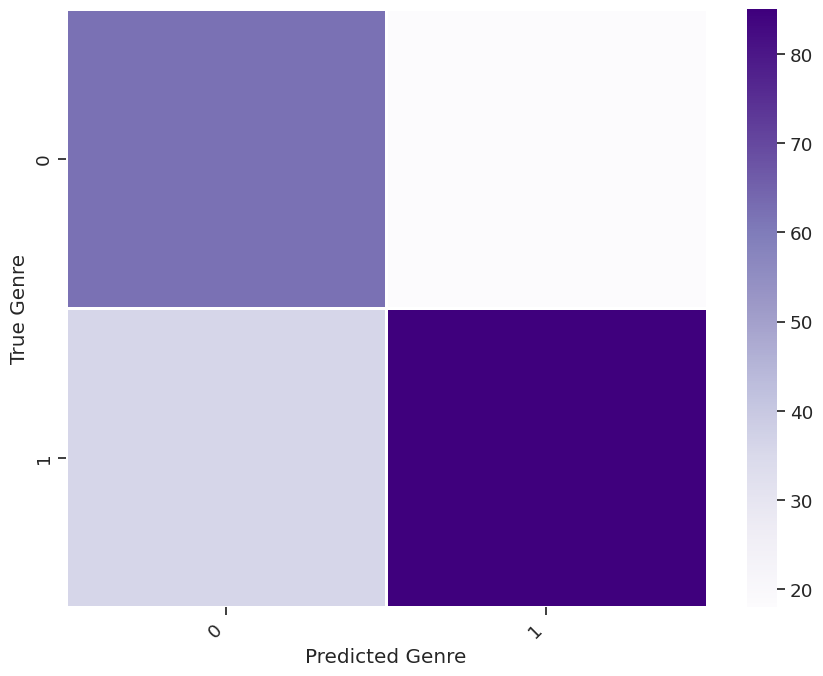

In [42]:
from collections import Counter

# Count the number of classifications for each genre pair
genre_classifications = Counter(zip(y_test, predicted_labels))

# Convert the counts to a DataFrame and pivot to wide format
df_wide = pd.DataFrame(genre_classifications, index=['Number of Classifications']).T.reset_index()
df_wide.columns = ['True Genre', 'Predicted Genre', 'Number of Classifications']
df_wide = df_wide.pivot_table(index='True Genre', columns='Predicted Genre', values='Number of Classifications', fill_value=0)

# Plot the results
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Looks good! We can see that overall, our model is assigning the correct labels for each genre.

Now, let's remove the diagonal from the plot to highlight the misclassifications.

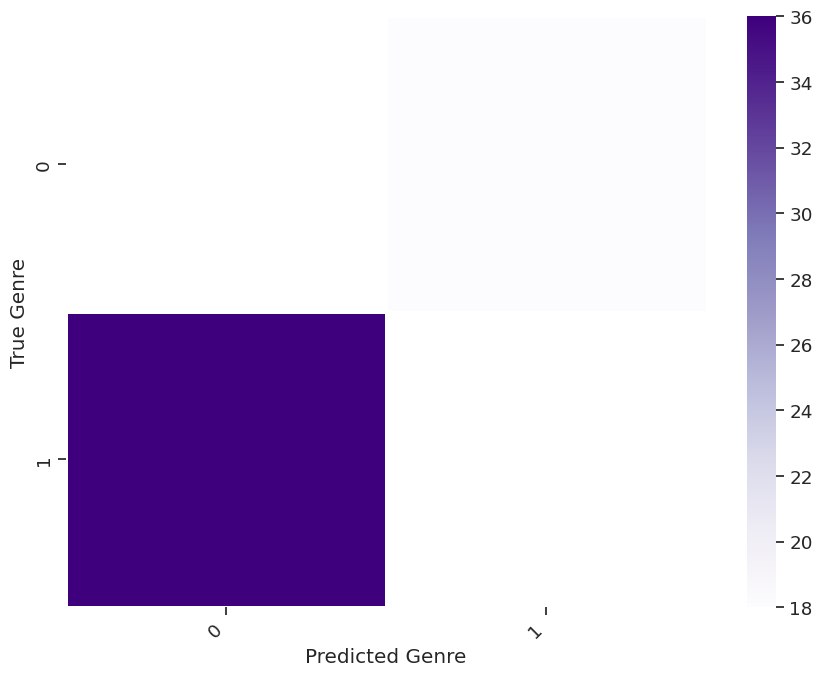

In [43]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(y_test, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()